In [ ]:

!pip install h5py
!pip install astropy
!pip install reproject

     |████████████████████████████████| 1.3MB 5.5MB/s 
     |████████████████████████████████| 204kB 34.0MB/s 


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from reproject import reproject_interp

## Download SDSS field images

Here we download full SDSS field images. We choose a couple frames to start from.  [SDSS bulk data download](https://dr12.sdss.org/bulkFields)  (Also see [here](https://www.sdss.org/dr12/data_access/bulk/) for bulk download commands.)

These are calibrated, sky-subtracted image fields. You can [learn more about them here](https://www.sdss.org/dr16/imaging/imaging_basics/), and see the full [data model here](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html).

In [ ]:
# Collect the filenames for the desired frames and filters
#'run-camcol-field'
frame_names = ['004570-4-0135', '001737-5-0039']
filters = ['g', 'r', 'i']
file_names = []
for frame_name in frame_names:
  for filter in filters:
    run, camcol, field = frame_name.split('-')
    run = run[2:]
    file_name = f'http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/{run}/{camcol}/frame-{filter}-{frame_name}.fits.bz2'
    file_names.append(file_name)

In [ ]:
# Download the files
for file_name in file_names:
  !wget $file_name

--2020-12-07 17:23:30--  http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/4570/4/frame-g-004570-4-0135.fits.bz2
Resolving data.sdss3.org (data.sdss3.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss3.org (data.sdss3.org)|155.101.19.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.sdss.org/sas/dr12/boss/photoObj/frames/301/4570/4/frame-g-004570-4-0135.fits.bz2 [following]
--2020-12-07 17:23:31--  https://data.sdss.org/sas/dr12/boss/photoObj/frames/301/4570/4/frame-g-004570-4-0135.fits.bz2
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2808943 (2.7M) [application/octet-stream]
Saving to: ‘frame-g-004570-4-0135.fits.bz2’

frame-g-004570-4-01 100%[===================>]   2.68M   690KB/s    in 4.0s    

2020-12-07 17:23:36 (690 KB/s) - ‘frame-g-0045

In [ ]:
# Construct data cubes
hdus = []
for frame_name in frame_names:
  im = []
  hdu_cube = {}
  for filter in filters:
    hdul = fits.open(f'frame-{filter}-{frame_name}.fits.bz2')
    hdu_cube[filter] = hdul[0]
  hdus.append(hdu_cube)

We want to convert these flux values to RGB values in order to visualize them. The standard method to do this is by Lupton et al (2004); see the details on [astropy](https://docs.astropy.org/en/stable/visualization/rgb.html#astropy-visualization-rgb).

In [ ]:
# Convert raw image data to RGB for visualization
# Adapted from https://notebook.community/LSSTC-DSFP/LSSTC-DSFP-Sessions/Session2/Day5/ImageVizSolutions
minimum = 0
Q = 8
stretch = 0.5

ims_rgb = []
for hdu_cube in hdus:

    g = hdu_cube['g']
    r = hdu_cube['r']
    i = hdu_cube['i']

    # remap r and i onto g
    r_new, r_mask = reproject_interp(r, g.header)
    i_new, i_mask = reproject_interp(i, g.header)

    # zero out the unmapped values
    i_new[np.logical_not(i_mask)] = 0
    r_new[np.logical_not(r_mask)] = 0

    # red=i, green=r, blue=g
    im_rgb = make_lupton_rgb(i_new, r_new, g.data, minimum=minimum, Q=Q, stretch=stretch)
    ims_rgb.append(im_rgb)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


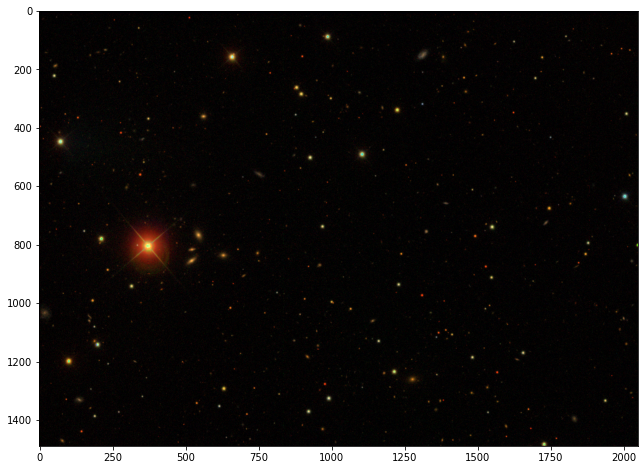

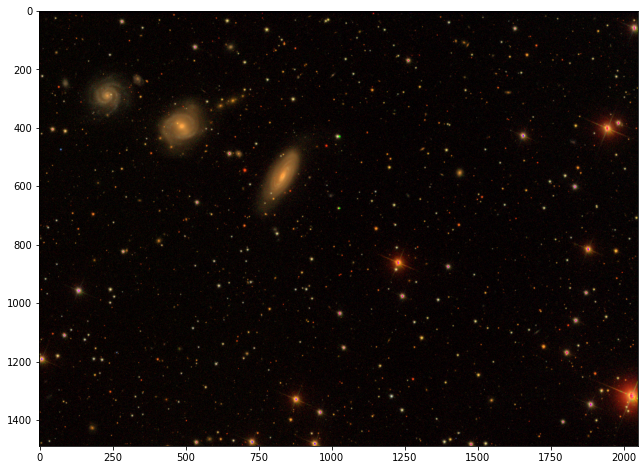

In [ ]:
# Draw images
for im in ims_rgb:
  plt.figure(figsize=(12,8))
  plt.imshow(im)

To extract scientific information from these images, we usually want cutouts ("postage stamps") of individual objects. The galaxy catalogs containing the object positions associated with these images can be downloaded from
```
http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-<run>-<camcol>-gal.fits.gz
```



This is a bit of an involved process. A method to quickly preview images is to download the pre-procossed JPG images. This can be down with the following command.

Let's get the image for the galaxy NGC 3521. We can use [SIMBAD](http://simbad.u-strasbg.fr/simbad/) to find the RA and dec for objects we know the names of. You'll also need to adjust the scale, depending on the distance to the object.

In [ ]:
RA=166.4524208
DEC=-0.0358639
SCALE=2
fn_jpg='ngc3521.pg'

!wget $'http://skyservice.pha.jhu.edu/DR10/ImgCutout/getjpeg.aspx?ra='$RA'&dec='$DEC'&scale='$SCALE'&width=300&height=300' -O $fn_jpg

--2020-12-07 17:26:24--  http://skyservice.pha.jhu.edu/DR10/ImgCutout/getjpeg.aspx?ra=166.4524208&dec=-0.0358639&scale=2&width=300&height=300
Resolving skyservice.pha.jhu.edu (skyservice.pha.jhu.edu)... 128.220.233.141
Connecting to skyservice.pha.jhu.edu (skyservice.pha.jhu.edu)|128.220.233.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7687 (7.5K) [image/jpeg]
Saving to: ‘ngc3521.pg’

ngc3521.pg          100%[===================>]   7.51K  --.-KB/s    in 0s      

2020-12-07 17:26:25 (649 MB/s) - ‘ngc3521.pg’ saved [7687/7687]



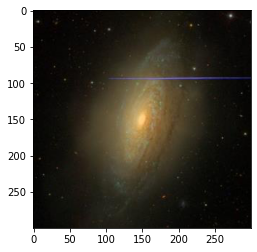

In [ ]:
img = mpimg.imread(fn_jpg)
plt.imshow(img)

Even this requires knowing the set of objects you want to download. For now, let's use a pre-packaged set of galaxy images:

## Quickstart: The MNIST of Galaxy Catalogs

We will use the Galaxy10 dataset, which is already nicely packaged for ML experimentation. These are 3-color image cutouts of galaxies in SDSS, classified into galaxy types by volunteers in the [Galaxy Zoo](https://www.galaxyzoo.org/) citizen science project. The data was processed by the [astroNN](https://astronn.readthedocs.io) team and more details can be found in the [documentation](https://astronn.readthedocs.io/en/latest/galaxy10.html).

Data for full science use cases can be downloaded directly from SDSS, using tools such as the [Image List](http://skyserver.sdss.org/dr12/en/tools/chart/listinfo.aspx).

In [ ]:
# The first time you run this notebook, download this dataset
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2020-12-07 17:28:15--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  16.1MB/s    in 20s     

2020-12-07 17:28:35 (9.90 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



In [ ]:
# Get the images and labels from file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

In [ ]:
Galaxy10Class = {0: "Disk, Face-on, No Spiral",
                 1: "Smooth, Completely round",
                 2: "Smooth, in-between round",
                 3: "Smooth, Cigar shaped",
                 4: "Disk, Edge-on, Rounded Bulge",
                 5: "Disk, Edge-on, Boxy Bulge",
                 6: "Disk, Edge-on, No Bulge",
                 7: "Disk, Face-on, Tight Spiral",
                 8: "Disk, Face-on, Medium Spiral",
                 9: "Disk, Face-on, Loose Spiral"}

Let's take a look at the galaxy images, taking a random selection from each of the 10 classes.

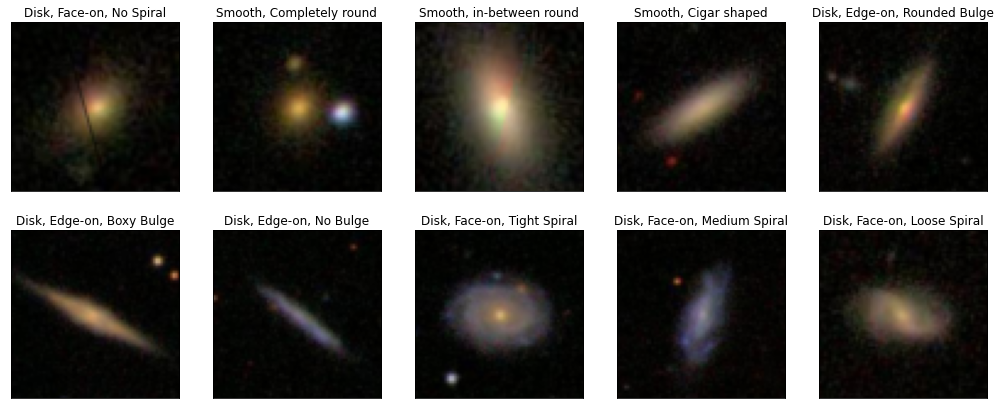

In [ ]:
nrows = 2
ncols = 5
subsize = 3.5
fig, axarr = plt.subplots(nrows, ncols, figsize=(ncols*subsize, nrows*subsize))

count = 0
for i in range(nrows):
  for j in range(ncols):
    ax = axarr[i][j]
    locs_in_class = np.where(labels==count)[0]
    loc = np.random.choice(locs_in_class)
    im = images[loc].astype(int)
    ax.imshow(im)
    ax.set_title(Galaxy10Class[labels[loc]])
    ax.set_xticks([])
    ax.set_yticks([])
    count += 1